# Data Analysis

- Analyzes collected meeting audio data for ML readiness and augmentation planning

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

Meeting Audio Dataset Analyzer
Loaded 8 sessions from master CSV
Starting Complete Dataset Analysis...

DATASET COVERAGE ANALYSIS
Basic Statistics:
   Total recordings: 8
   Total duration: 42.5 minutes
   Average duration: 319.1 seconds
   Total samples: 4,072
   Sample rate: ~1.6 samples/second

Label Distribution:

   Speaker Count:
      3+: 4 (50.0%)
      2: 2 (25.0%)
      unknown: 1 (12.5%)
      3: 1 (12.5%)
1 unknown labels need classification

   Meeting Type:
      discussion: 3 (37.5%)
      presentation: 2 (25.0%)
      unknown: 1 (12.5%)
      argument: 1 (12.5%)
      brainstorm: 1 (12.5%)
1 unknown labels need classification

   Energy Level:
      high: 3 (37.5%)
      medium: 3 (37.5%)
      unknown: 2 (25.0%)
2 unknown labels need classification

   Background Noise:
      low: 2 (25.0%)
      high: 2 (25.0%)
      medium: 2 (25.0%)
      unknown: 1 (12.5%)
      none: 1 (12.5%)
1 unknown labels need classification

GAP ANALYSIS:
   1. Missing 1-speaker scenarios (p

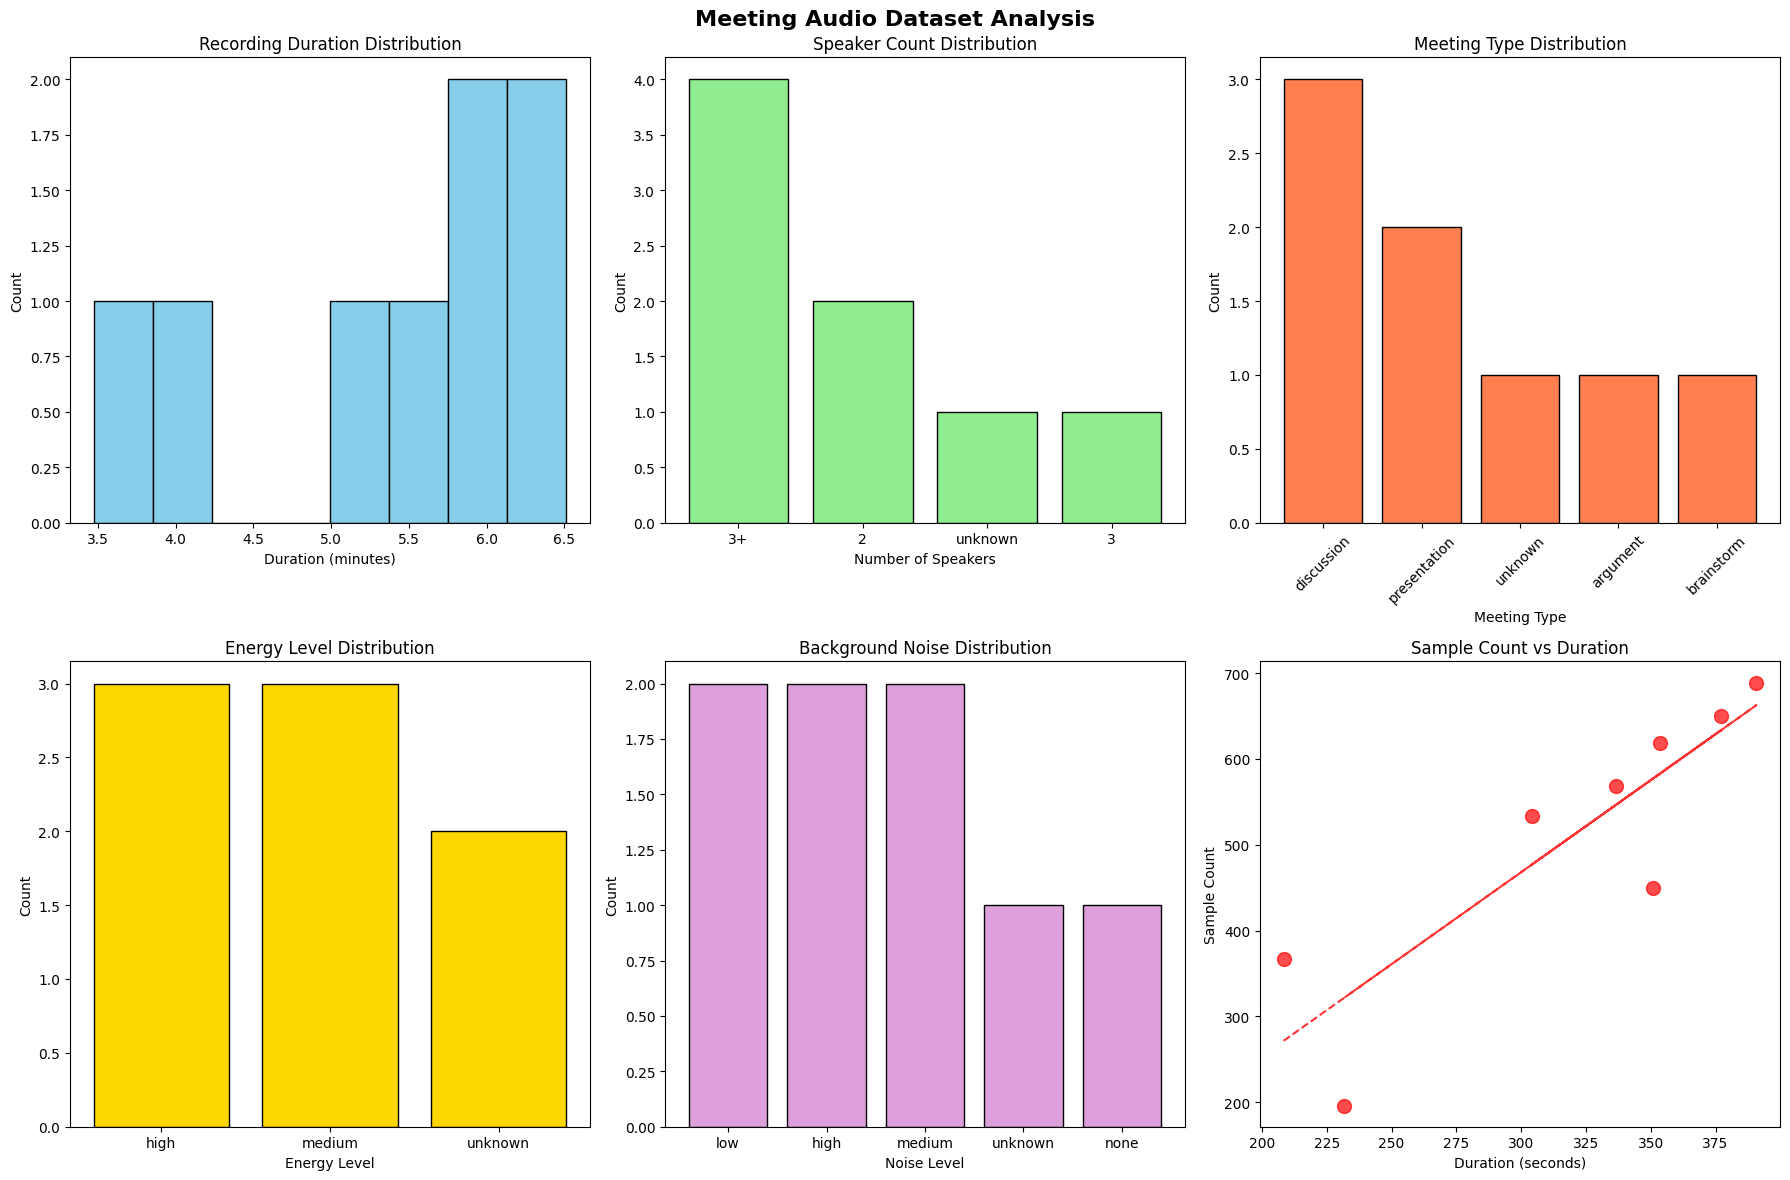


 AUGMENTATION STRATEGY:

GAP ANALYSIS:
   1. Missing 1-speaker scenarios (presentations, monologues)
   2. Need more 'brainstorm' meetings (have 1)
   3. Need more 'argument' meetings (have 1)
   4. Missing low-energy meetings
   Augmentation Targets:
   Original recordings: 8
   Target samples per recording: 60
   Total synthetic samples: 480

    Augmentation Techniques:
   1. Time stretching: 0.8x, 0.9x, 1.1x, 1.2x speed (4 variants)
   2. Pitch shifting: ±1, ±2 semitones (4 variants)
   3. Stereo positioning: simulate different speaker locations (8 variants)
   4. Background noise mixing: add different noise levels (6 variants)
   5. Meeting flow simulation: modify turn-taking patterns (4 variants)
   6. Energy level adjustment: simulate low energy from medium (3 variants)

Gap-Specific Augmentation:
   → Remove one channel + reduce stereo variation
   → Rapid speaker switching + high energy for brainstorming
   → Increase interruptions + volume spikes for argument scenarios
   → 

In [4]:
class MeetingDatasetAnalyzer:
    def __init__(self, data_dir="./"):
        self.data_dir = Path(data_dir)
        self.recordings_dir = self.data_dir / "recordings"
        self.labels_dir = self.data_dir / "labels"
        
        # Load master CSV
        self.master_csv = self.labels_dir / "sessions_master.csv"
        if self.master_csv.exists():
            self.df = pd.read_csv(self.master_csv)
            print(f"Loaded {len(self.df)} sessions from master CSV")
        else:
            print("sessions_master.csv not found!")
            return
        
        # Audio data storage
        self.audio_data = {}
        self.audio_features = {}
        
    def load_audio_data(self):
        """Load all audio data files"""
        print("\nLoading audio data...")
        
        for _, session in self.df.iterrows():
            session_id = session['session_id']
            audio_file = self.recordings_dir / f"{session_id}_audio.json"
            
            if audio_file.exists():
                with open(audio_file, 'r') as f:
                    self.audio_data[session_id] = json.load(f)
                print(f"Loaded {session_id}: {len(self.audio_data[session_id])} samples")
            else:
                print(f"Missing audio file: {audio_file}")
    
    def analyze_dataset_coverage(self):
        """Analyze dataset coverage and identify gaps"""
        print("\n" + "="*60)
        print("DATASET COVERAGE ANALYSIS")
        print("="*60)
        
        # Basic statistics
        total_duration = self.df['duration_seconds'].sum()
        avg_duration = self.df['duration_seconds'].mean()
        total_samples = self.df['sample_count'].sum()
        
        print(f"Basic Statistics:")
        print(f"   Total recordings: {len(self.df)}")
        print(f"   Total duration: {total_duration/60:.1f} minutes")
        print(f"   Average duration: {avg_duration:.1f} seconds")
        print(f"   Total samples: {total_samples:,}")
        print(f"   Sample rate: ~{total_samples/total_duration:.1f} samples/second")
        
        # Label distribution analysis
        print(f"\nLabel Distribution:")
        
        categories = ['speaker_count', 'meeting_type', 'energy_level', 'background_noise']
        
        for category in categories:
            print(f"\n   {category.replace('_', ' ').title()}:")
            value_counts = self.df[category].value_counts()
            for value, count in value_counts.items():
                percentage = (count / len(self.df)) * 100
                print(f"      {value}: {count} ({percentage:.1f}%)")
            
            # Identify gaps
            if 'unknown' in value_counts:
                print(f"{value_counts['unknown']} unknown labels need classification")
        
        return self.identify_gaps()
    
    def identify_gaps(self):
        """Identify gaps in dataset for targeted augmentation"""
        print(f"\nGAP ANALYSIS:")
        
        gaps = []
        
        # Speaker count gaps
        speaker_counts = self.df['speaker_count'].value_counts()
        if '1' not in speaker_counts:
            gaps.append("Missing 1-speaker scenarios (presentations, monologues)")
        
        # Meeting type gaps
        meeting_types = self.df['meeting_type'].value_counts()
        expected_types = ['discussion', 'presentation', 'brainstorm', 'argument']
        for meet_type in expected_types:
            if meet_type not in meeting_types or meeting_types[meet_type] < 2:
                gaps.append(f"Need more '{meet_type}' meetings (have {meeting_types.get(meet_type, 0)})")
        
        # Energy level gaps
        energy_levels = self.df['energy_level'].value_counts()
        if 'low' not in energy_levels:
            gaps.append("Missing low-energy meetings")
        
        # Print gaps
        if gaps:
            for i, gap in enumerate(gaps, 1):
                print(f"   {i}. {gap}")
        else:
            print("No major gaps identified!")
        
        return gaps
    
    def extract_audio_features(self):
        """Extract features from audio data for analysis"""
        print("\nExtracting audio features...")
        
        if not self.audio_data:
            self.load_audio_data()
        
        for session_id, audio_samples in self.audio_data.items():
            features = self.calculate_audio_features(audio_samples)
            self.audio_features[session_id] = features
            print(f"Features extracted for {session_id}")
    
    def calculate_audio_features(self, audio_samples):
        """Calculate audio features from sample data"""
        if not audio_samples:
            return {}
        
        # Convert to numpy arrays
        left_levels = np.array([s['leftMic'] for s in audio_samples])
        right_levels = np.array([s['rightMic'] for s in audio_samples])
        differences = np.array([s['difference'] for s in audio_samples])
        avg_levels = np.array([s['averageLevel'] for s in audio_samples])
        
        features = {
            # Volume statistics
            'avg_volume': np.mean(avg_levels),
            'max_volume': np.max(avg_levels),
            'min_volume': np.min(avg_levels),
            'volume_std': np.std(avg_levels),
            'volume_range': np.max(avg_levels) - np.min(avg_levels),
            
            # Stereo positioning
            'avg_stereo_diff': np.mean(np.abs(differences)),
            'max_stereo_diff': np.max(np.abs(differences)),
            'stereo_variation': np.std(differences),
            
            # Activity patterns
            'high_activity_ratio': np.sum(avg_levels > np.mean(avg_levels) + np.std(avg_levels)) / len(avg_levels),
            'silence_ratio': np.sum(avg_levels < 40) / len(avg_levels),  # Below 40dB considered silence
            
            # Temporal patterns
            'volume_changes': np.sum(np.abs(np.diff(avg_levels)) > 5),  # Significant volume changes
            'stereo_switches': np.sum(np.abs(np.diff(differences)) > 3),  # Speaker position changes
        }
        
        return features
    
    def create_visualizations(self):
        """Create visualization plots for dataset analysis"""
        print("\nCreating visualizations...")
        
        # Set up the plotting style
        plt.style.use('default')
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Meeting Audio Dataset Analysis', fontsize=16, fontweight='bold')
        
        # 1. Duration distribution
        axes[0,0].hist(self.df['duration_seconds']/60, bins=8, color='skyblue', edgecolor='black')
        axes[0,0].set_title('Recording Duration Distribution')
        axes[0,0].set_xlabel('Duration (minutes)')
        axes[0,0].set_ylabel('Count')
        
        # 2. Speaker count distribution
        speaker_counts = self.df['speaker_count'].value_counts()
        axes[0,1].bar(speaker_counts.index, speaker_counts.values, color='lightgreen', edgecolor='black')
        axes[0,1].set_title('Speaker Count Distribution')
        axes[0,1].set_xlabel('Number of Speakers')
        axes[0,1].set_ylabel('Count')
        
        # 3. Meeting type distribution
        meeting_types = self.df['meeting_type'].value_counts()
        axes[0,2].bar(meeting_types.index, meeting_types.values, color='coral', edgecolor='black')
        axes[0,2].set_title('Meeting Type Distribution')
        axes[0,2].set_xlabel('Meeting Type')
        axes[0,2].set_ylabel('Count')
        axes[0,2].tick_params(axis='x', rotation=45)
        
        # 4. Energy level distribution
        energy_levels = self.df['energy_level'].value_counts()
        axes[1,0].bar(energy_levels.index, energy_levels.values, color='gold', edgecolor='black')
        axes[1,0].set_title('Energy Level Distribution')
        axes[1,0].set_xlabel('Energy Level')
        axes[1,0].set_ylabel('Count')
        
        # 5. Background noise distribution
        bg_noise = self.df['background_noise'].value_counts()
        axes[1,1].bar(bg_noise.index, bg_noise.values, color='plum', edgecolor='black')
        axes[1,1].set_title('Background Noise Distribution')
        axes[1,1].set_xlabel('Noise Level')
        axes[1,1].set_ylabel('Count')
        
        # 6. Sample count vs duration
        axes[1,2].scatter(self.df['duration_seconds'], self.df['sample_count'], 
                         color='red', alpha=0.7, s=100)
        axes[1,2].set_title('Sample Count vs Duration')
        axes[1,2].set_xlabel('Duration (seconds)')
        axes[1,2].set_ylabel('Sample Count')
        
        # Add trend line
        z = np.polyfit(self.df['duration_seconds'], self.df['sample_count'], 1)
        p = np.poly1d(z)
        axes[1,2].plot(self.df['duration_seconds'], p(self.df['duration_seconds']), "r--", alpha=0.8)
        
        plt.tight_layout()
        plt.savefig('dataset_analysis.png', dpi=300, bbox_inches='tight')
        print("Saved dataset analysis plot: dataset_analysis.png")
        plt.show()
    
    def analyze_audio_quality(self):
        """Analyze audio quality and patterns"""
        if not self.audio_features:
            self.extract_audio_features()
        
        print("\n AUDIO QUALITY ANALYSIS:")
        print("="*60)
        
        # Merge features with session metadata
        feature_df = pd.DataFrame(self.audio_features).T
        feature_df['session_id'] = feature_df.index
        merged_df = pd.merge(self.df, feature_df, on='session_id')
        
        # Audio quality metrics
        print(f"   Audio Level Statistics:")
        print(f"   Average volume: {merged_df['avg_volume'].mean():.1f} ± {merged_df['avg_volume'].std():.1f} dB")
        print(f"   Volume range: {merged_df['volume_range'].mean():.1f} ± {merged_df['volume_range'].std():.1f} dB")
        print(f"   Stereo separation: {merged_df['avg_stereo_diff'].mean():.1f} ± {merged_df['avg_stereo_diff'].std():.1f} dB")
        
        # Activity analysis
        print(f"\n Activity Patterns:")
        print(f"   High activity ratio: {merged_df['high_activity_ratio'].mean():.1%}")
        print(f"   Silence ratio: {merged_df['silence_ratio'].mean():.1%}")
        print(f"   Speaker switches: {merged_df['stereo_switches'].mean():.1f} per session")
        
        # Quality flags
        print(f"\n Quality Checks:")
        low_volume_sessions = merged_df[merged_df['avg_volume'] < 50]
        if len(low_volume_sessions) > 0:
            print(f"   {len(low_volume_sessions)} sessions with low volume (< 50dB)")
        
        low_stereo_sessions = merged_df[merged_df['avg_stereo_diff'] < 1]
        if len(low_stereo_sessions) > 0:
            print(f"   {len(low_stereo_sessions)} sessions with poor stereo separation (< 1dB)")
        
        high_silence_sessions = merged_df[merged_df['silence_ratio'] > 0.3]
        if len(high_silence_sessions) > 0:
            print(f"   {len(high_silence_sessions)} sessions with high silence ratio (> 30%)")
        
        if len(low_volume_sessions) == 0 and len(low_stereo_sessions) == 0 and len(high_silence_sessions) == 0:
            print("All sessions pass quality checks!")
        
        return merged_df
    
    def generate_augmentation_plan(self):
        """Generate specific augmentation plan based on gaps"""
        print("\n AUGMENTATION STRATEGY:")
        print("="*60)
        
        gaps = self.identify_gaps()
        
        # Calculate target samples per category
        target_samples_per_category = 60  # 60 samples from each original recording
        total_original_samples = len(self.df)
        target_total_samples = total_original_samples * target_samples_per_category
        
        print(f"   Augmentation Targets:")
        print(f"   Original recordings: {total_original_samples}")
        print(f"   Target samples per recording: {target_samples_per_category}")
        print(f"   Total synthetic samples: {target_total_samples}")
        
        # Specific augmentation techniques
        print(f"\n    Augmentation Techniques:")
        print(f"   1. Time stretching: 0.8x, 0.9x, 1.1x, 1.2x speed (4 variants)")
        print(f"   2. Pitch shifting: ±1, ±2 semitones (4 variants)")
        print(f"   3. Stereo positioning: simulate different speaker locations (8 variants)")
        print(f"   4. Background noise mixing: add different noise levels (6 variants)")
        print(f"   5. Meeting flow simulation: modify turn-taking patterns (4 variants)")
        print(f"   6. Energy level adjustment: simulate low energy from medium (3 variants)")
        
        # Gap-specific strategies
        print(f"\nGap-Specific Augmentation:")
        for gap in gaps:
            if "low-energy" in gap:
                print(f"   → Volume reduction + slower tempo for low-energy meetings")
            elif "argument" in gap:
                print(f"   → Increase interruptions + volume spikes for argument scenarios")
            elif "brainstorm" in gap:
                print(f"   → Rapid speaker switching + high energy for brainstorming")
            elif "1-speaker" in gap:
                print(f"   → Remove one channel + reduce stereo variation")
  
        return target_total_samples
    
    def run_complete_analysis(self):
        """Run complete dataset analysis"""
        print("Starting Complete Dataset Analysis...")
        print("="*80)
        
        # 1. Dataset coverage analysis
        gaps = self.analyze_dataset_coverage()
        
        # 2. Load and analyze audio data
        self.load_audio_data()
        self.extract_audio_features()
        
        # 3. Audio quality analysis
        merged_df = self.analyze_audio_quality()
        
        # 4. Create visualizations
        self.create_visualizations()
        
        # 5. Generate augmentation plan
        target_samples = self.generate_augmentation_plan()
        
        # 6. Summary and recommendations
        print("\n" + "="*80)
        print("ANALYSIS SUMMARY")
        print("="*80)
        
        print(f"   - {len(self.df)} recordings with good variety")
        print(f"   - ~{self.df['duration_seconds'].sum()/60:.0f} minutes of real meeting audio")
        print(f"   - Strong stereo positioning data")
        print(f"   - Authentic meeting dynamics")
        
        print(f"\nReady for Augmentation since:")
        print(f"   - Target: {target_samples} synthetic samples")
        print(f"   - 8 original → 500+ augmented samples")
        print(f"   - Balanced across all categories")
        
        print(f"\nML Models will train:")
        print(f"   1. Speaker Count Classifier (2, 3, 3+ speakers)")
        print(f"   2. Meeting Type Classifier (discussion, presentation, brainstorm, argument)")
        print(f"   3. Energy Level Predictor (low, medium, high)")
        print(f"   4. Background Noise Classifier (none, low, medium, high)")
        print(f"   5. Engagement Score Regressor (based on audio dynamics)")
        
        print(f"\nMy next steps:")
        print(f"   1. Run augmentation pipeline")
        print(f"   2. Train initial ML models")
        print(f"   3. Validate on real test data")
        print(f"   4. Deploy to your web interface")
        
        return merged_df

def main():
    """Main analysis function"""
    print("Meeting Audio Dataset Analyzer")
    print("="*50)
    
    # Create analyzer instance
    analyzer = MeetingDatasetAnalyzer()
    
    # Run complete analysis
    results = analyzer.run_complete_analysis()
    
    print("\nAnalysis complete! Check 'dataset_analysis.png' for visualizations.")
    
    return analyzer, results

if __name__ == "__main__":
    analyzer, results = main()